<h1 style="font-size:3em; text-align: center">Adjusting Loss Function to Favor Underestimates</h1>

Because it is more costly to send more self driving vehicles to a location than the domand calls for, we want the LSTM to consistently under-estimate the true value of the demand at a given time rather than over-estimate.

To do so we adopted the loss function given in https://datascience.stackexchange.com/questions/10471/linear-regression-with-non-symmetric-cost-function to limit the probability of the LSTM to only over-estimate no more than 10% of the time.


In [58]:
# imports
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras
from scipy.stats  import norm
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras        import backend as K
from datetime     import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from matplotlib.pylab      import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 6

# number of inputs to be fed
look_back = 288
# number of outputs to be generated
look_forward = 24

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)

# Returns the predicted values of the LSTM
def predictNext2Hours (model, dataset):
    dataset = np.array(dataset)
    # normalize
    dataset = dataset.transpose().reshape(-1, 1)
    dataset = scaler.fit_transform(dataset).transpose()
    data = dataset.T
    data = data.reshape(1, 1, data.shape[0])
    # make a prediction
    prediction = model.predict(data)
    return scaler.inverse_transform(prediction)

# given a two matrices of same size, it
# (1) calculates what percentage of predictions are overestimates of the true values
# (2) graphs the error of the 24 predictions
def show_prediction_error (true, pred):
    # calculates the percent of the predictions that are overestimating
    percent_overestimating = 100.0 * (true - pred < 0).sum() / pred.size
    print "Percent Overestimating: {}".format( percent_overestimating )
    for i in range(look_forward):
        # calc individial errors
        indiv_err = true[:,i] - pred[:,i]
        plt.scatter(np.ones(len(indiv_err))*i, indiv_err, color='black', alpha=0.1)
    plt.axhline(0)
    plt.show()

# The Prediction function, makes and graphs predictions from the predicNext2Hours function 
def predict (model=model, day=11, total_days=1, delta=1, show_gradual_error=True):
    
    predictions = np.ones((288*total_days/delta, look_forward))
    true_vals = np.ones((288*total_days/delta, look_forward))
    
    # makes all the predictions and graphs them
    for i in range (288*total_days/delta):
        point = 288*day + i * delta
        prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back))
        prediction = prediction.reshape(look_forward)
        predictions[i] = prediction
        true_vals[i]   = dataset_orig[point:point+look_forward].reshape(look_forward)
        plt.plot(np.arange(look_forward) + point,prediction, color='red', alpha=0.1)
    # graphs the true values for the day, and the horizontal line
    plt.plot( np.arange(288*total_days+look_forward) + 288 * day, 
             dataset_orig[288*day:288*day+288*total_days + look_forward,0])
    plt.axhline(0)
    plt.show()
    if show_gradual_error:
        show_prediction_error(true_vals, predictions)

# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5500)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)
# split into train and test sets
train_size = 288*10
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


Epoch 1/5
6s - loss: 0.0048
Epoch 2/5
6s - loss: 0.0028
Epoch 3/5
6s - loss: 0.0024
Epoch 4/5
6s - loss: 0.0022
Epoch 5/5
6s - loss: 0.0020


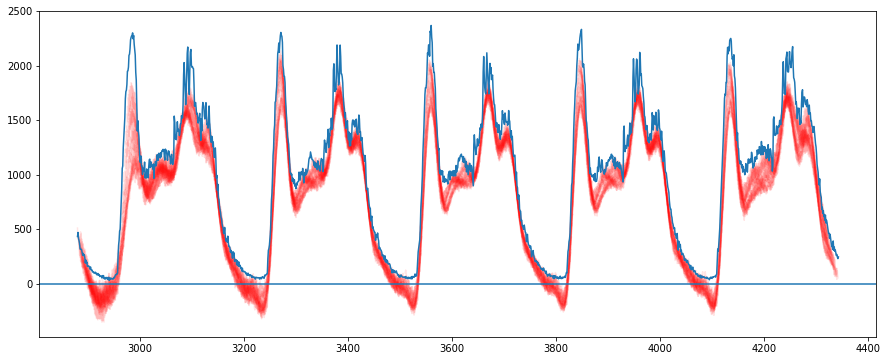

Percent Overestimating: 3.58217592593


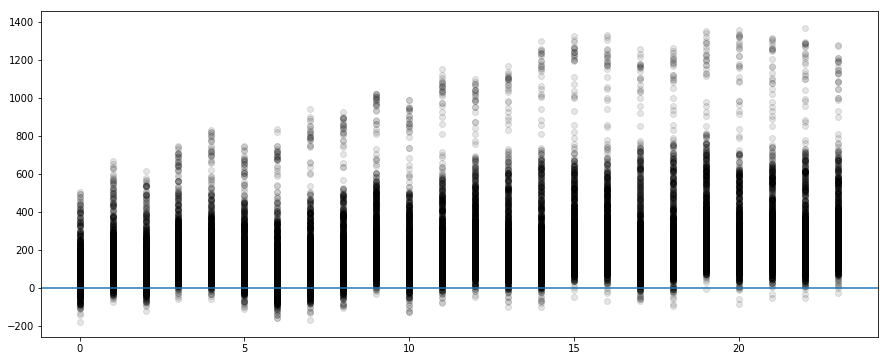

In [64]:
def over_penalty(y_true, y_pred):
    true_error = y_true - y_pred
    # doubles the error if the prediction is negative
    return  K.square(true_error) * K.square(K.sign(true_error) - 0.55);

# batch size
b = 1
# value for the random seed
seed = 10
np.random.seed(seed)
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(look_forward))
model.compile(loss=over_penalty, optimizer=keras.optimizers.RMSprop(lr=0.0002, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=b, verbose=2)
predict(model=model,total_days=5,day=10,delta=1)